In [ ]:
!pip install gdown

In [ ]:
!gdown https://drive.google.com/file/d/1xvQdCHOZAtCSnv8HlZiNfOovj_JKjcoi/view?usp=drive_link
1

/usr/local/lib/python3.11/dist-packages/gdown/parse_url.py:48: UserWarning: You specified a Google Drive link that is not the correct link to download a file. You might want to try `--fuzzy` option or the following url: https://drive.google.com/uc?id=1xvQdCHOZAtCSnv8HlZiNfOovj_JKjcoi
  warnings.warn(
Downloading...
From: https://drive.google.com/file/d/1xvQdCHOZAtCSnv8HlZiNfOovj_JKjcoi/view?usp=drive_link
To: /content/view?usp=drive_link
8.92kB [00:00, 14.1MB/s]


In [ ]:
!unzip "/content/FruitinAmazon.zip"

Archive:  /content/FruitinAmazon.zip
  inflating: FruitinAmazon/test/cupuacu/download (5).jpeg  
  inflating: FruitinAmazon/test/acai/images (2).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (3).jpeg  
  inflating: FruitinAmazon/test/acai/images (16).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (2).jpeg  
  inflating: FruitinAmazon/train/pupunha/images (1).jpeg  
  inflating: FruitinAmazon/test/cupuacu/download (2).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (1).jpeg  
  inflating: FruitinAmazon/train/acai/images (3).jpeg  
  inflating: FruitinAmazon/train/acai/images (4).jpeg  
  inflating: FruitinAmazon/test/graviola/download (1).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (11).jpeg  
  inflating: FruitinAmazon/test/pupunha/download (4).jpeg  
  inflating: FruitinAmazon/train/acai/images (11).jpeg  
  inflating: FruitinAmazon/test/tucuma/download (1).jpeg  
  inflating: FruitinAmazon/test/acai/images.jpeg  
  inflating: FruitinAmazon/train


### **Task 1: Data Understanding and Visualization**
#### **1.1 Load and Visualize Images**


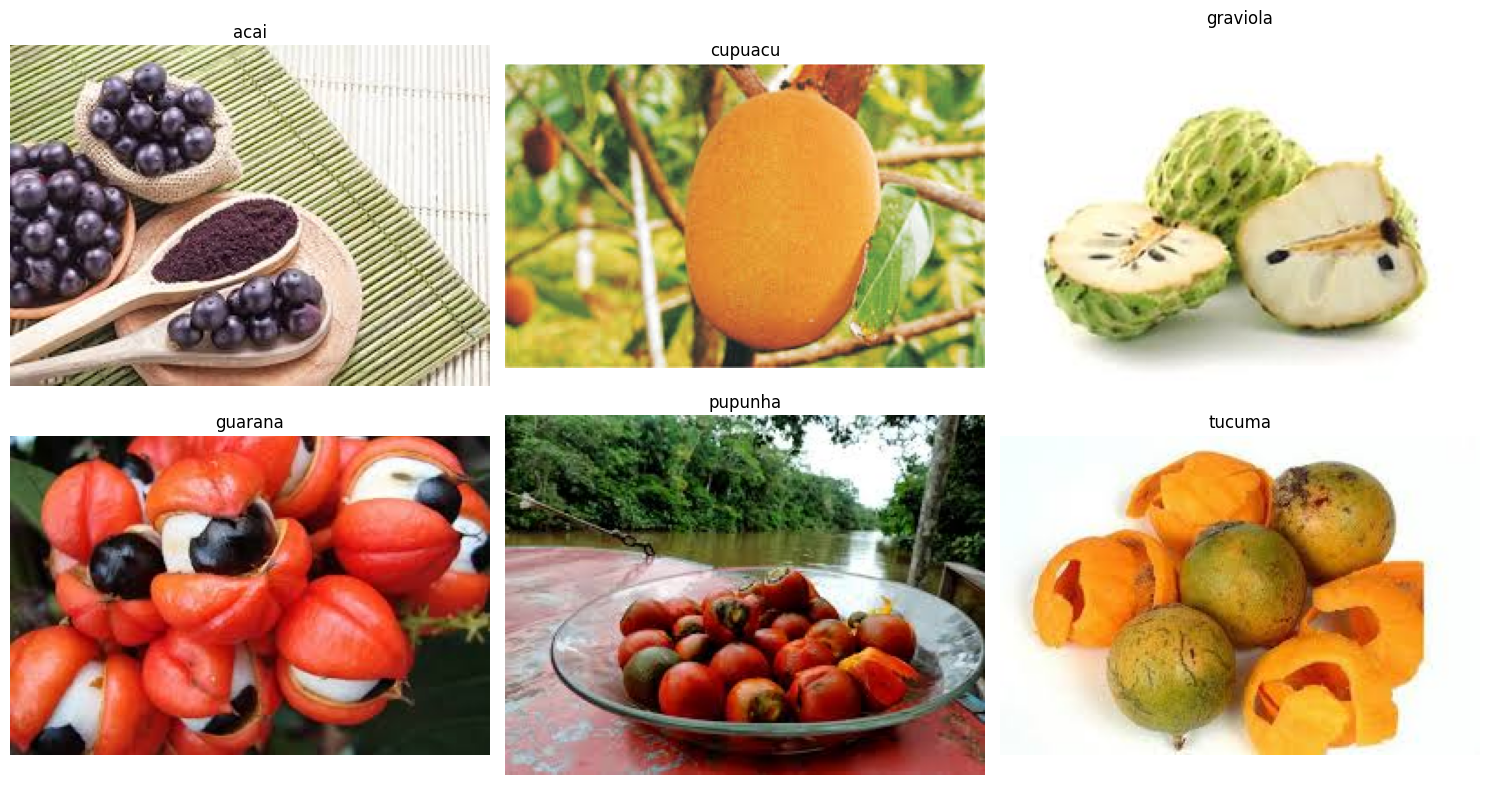

In [ ]:
import os
import matplotlib.pyplot as plt
import random
from PIL import Image

train_dir = "/content/FruitinAmazon/train"  # Update with your path
class_names = sorted(os.listdir(train_dir))

# Plot 2x3 grid of images
fig, axes = plt.subplots(2, 3, figsize=(15, 8))
for i, class_name in enumerate(class_names):
    class_path = os.path.join(train_dir, class_name)
    images = os.listdir(class_path)
    img_name = random.choice(images)
    img = Image.open(os.path.join(class_path, img_name))
    row, col = i // 3, i % 3
    axes[row, col].imshow(img)
    axes[row, col].set_title(class_name)
    axes[row, col].axis('off')
plt.tight_layout()
plt.show()


#### **1.2 Check for Corrupted Images**

In [ ]:
corrupted = []
for class_name in class_names:
    class_path = os.path.join(train_dir, class_name)
    for img_name in os.listdir(class_path):
        img_path = os.path.join(class_path, img_name)
        try:
            with Image.open(img_path) as img:
                img.verify()
        except (IOError, SyntaxError):
            os.remove(img_path)
            corrupted.append(img_path)
            print(f"Removed corrupted image: {img_path}")
if not corrupted:
    print("No corrupted images found.")


No corrupted images found.


### **Task 2: Loading and Preprocessing Data**

In [ ]:
import tensorflow as tf

# Parameters
img_height, img_width = 128, 128
batch_size = 32
validation_split = 0.2

# Load datasets
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=True,
    validation_split=validation_split,
    subset="training",
    seed=123
)

val_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False,
    validation_split=validation_split,
    subset="validation",
    seed=123
)

# Normalize pixel values
normalization = tf.keras.layers.Rescaling(1./255)
train_ds = train_ds.map(lambda x, y: (normalization(x), y))
val_ds = val_ds.map(lambda x, y: (normalization(x), y))

# Load test data
test_dir = "/content/FruitinAmazon/test"  # Update with your path
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    labels="inferred",
    label_mode="int",
    image_size=(img_height, img_width),
    batch_size=batch_size,
    shuffle=False
).map(lambda x, y: (normalization(x), y))


Found 90 files belonging to 6 classes.
Using 72 files for training.
Found 90 files belonging to 6 classes.
Using 18 files for validation.
Found 30 files belonging to 6 classes.



### **Task 3: Implement CNN Model**


In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu", input_shape=(128, 128, 3)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Conv2D(32, (3, 3), padding="same", activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(128, activation="relu"),
    tf.keras.layers.Dense(len(class_names), activation="softmax")
])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)



### **Task 4: Compile and Train Model**


In [ ]:
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# Callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "best_model.h5",
    monitor="val_accuracy",
    save_best_only=True,
    mode="max"
)
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True
)

# Train
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=250,
    batch_size=16,
    callbacks=[checkpoint, early_stop]
)


Epoch 1/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 508ms/step - accuracy: 0.1655 - loss: 2.1044

3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 725ms/step - accuracy: 0.1623 - loss: 2.1379 - val_accuracy: 0.0556 - val_loss: 1.9660
Epoch 2/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 534ms/step - accuracy: 0.4201 - loss: 1.6409

3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 677ms/step - accuracy: 0.4193 - loss: 1.6418 - val_accuracy: 0.6667 - val_loss: 1.3946
Epoch 3/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 448ms/step - accuracy: 0.3850 - loss: 1.5302 - val_accuracy: 0.6667 - val_loss: 1.2559
Epoch 4/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 443ms/step - accuracy: 0.4284 - loss: 1.3410 - val_accuracy: 0.5556 - val_loss: 1.2466
Epoch 5/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 358ms/step - accuracy: 0.5932 - loss: 1.0623

3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 512ms/step - accuracy: 0.6046 - loss: 1.0635 - val_accuracy: 0.8889 - val_loss: 0.6631
Epoch 6/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 494ms/step - accuracy: 0.7036 - loss: 0.8713 - val_accuracy: 0.6111 - val_loss: 1.2486
Epoch 7/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 433ms/step - accuracy: 0.8186 - loss: 0.6862 - val_accuracy: 0.8333 - val_loss: 0.7889
Epoch 8/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 744ms/step - accuracy: 0.9232 - loss: 0.5100 - val_accuracy: 0.8333 - val_loss: 0.4539
Epoch 9/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 559ms/step - accuracy: 0.9518 - loss: 0.3354 - val_accuracy: 0.8333 - val_loss: 0.7142
Epoch 10/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 444ms/step - accuracy: 0.9891 - loss: 0.2344 - val_accuracy: 0.8333 - val_loss: 0.5099
Epoch 11/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 411ms/step - accuracy: 0.9891 - loss: 0.1482 - val_accuracy: 0.8889 - val_loss: 0.3473
Epoch 12/250
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 431ms/step - accuracy: 0.9813 - loss: 0.0807 - val_accuracy: 0.8889 - val_loss: 

### **Task 5: Evaluate Model**

In [ ]:
test_loss, test_acc = model.evaluate(test_ds)
print(f"Test Accuracy: {test_acc:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 271ms/step - accuracy: 0.7000 - loss: 0.7420
Test Accuracy: 0.7000


### **Task 6: Save and Load Model**

In [ ]:
model.save("fruit_classifier.h5")
loaded_model = tf.keras.models.load_model("fruit_classifier.h5")
loaded_model.evaluate(test_ds)  # Verify performance


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 638ms/step - accuracy: 0.7000 - loss: 0.7420


[0.7420015931129456, 0.699999988079071]

### **Task 7: Predictions and Classification Report**

In [ ]:
import numpy as np
from sklearn.metrics import classification_report

# Get true labels
y_true = np.concatenate([y.numpy() for _, y in test_ds], axis=0)

# Predict
y_pred = model.predict(test_ds)
y_pred_labels = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_true, y_pred_labels, target_names=class_names))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 565ms/step
              precision    recall  f1-score   support

        acai       0.75      0.60      0.67         5
     cupuacu       0.43      0.60      0.50         5
    graviola       0.71      1.00      0.83         5
     guarana       1.00      0.80      0.89         5
     pupunha       0.71      1.00      0.83         5
      tucuma       1.00      0.20      0.33         5

    accuracy                           0.70        30
   macro avg       0.77      0.70      0.68        30
weighted avg       0.77      0.70      0.68        30



### **Visualize Training History**

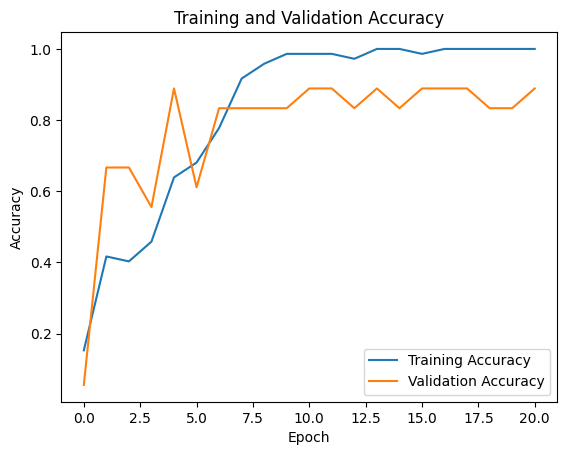

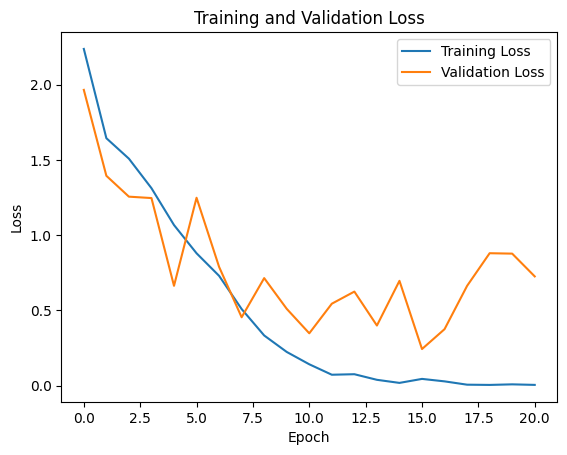

In [ ]:
# Plot accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()
f